<a href="https://colab.research.google.com/github/visiont3lab/deep-learning-course/blob/main/colab/TransferLearningBeesAnts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Tecniques

In this notebook we will focus our attention on:

**Theory**
* Modern Deep Learning Architecture for classification:

  * Google Net / Inception
  * ResNet (Residual)
  * VGG
* Transfer Learning Tecniques.
* Optimizers: Adadelta, Adaboost, Adam, SGD
* Trainining tricks: learning rate scheduler (cosine annealing, exponetial decay, reduce on plateau), checkpoints, sanity check.
* Vanishing gradients Problem (deep network): Dropout, Batch Normalization. 
* Difference between using model in Training and Test (evaluation) situation.

**Practical Example**
* Definition of a class for loading large data by using filepaths information.
* Definition of a full training testing pipeline with checkpoints, learning rate
* Transfer learning example. [example pytorch transfer learning differentiate between bee and ants](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Utils

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader,Dataset
from torch import optim
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import cv2
import torch.nn as nn
import os
from PIL import Image
from datetime import datetime
import pandas as pd
import cv2
import numpy as np
import shutil
import random
from torchsummary import summary
import copy
import plotly.graph_objects as go
import torchvision.models as models

### Training Functions

In [117]:
# validation metric classification
def metrics_func_classification(target, output):
    # Compute number of correct prediction
    pred = output.argmax(dim=-1,keepdim=True)
    corrects =pred.eq(target.reshape(pred.shape)).sum().item()
    return -corrects # minus for coeherence with best result is the most negative one

# training: loss calculation and backward step
def loss_batch(loss_func,metric_func, xb,yb,yb_h, opt=None):
    # obtain loss
    loss = loss_func(yb_h, yb)
    # obtain performance metric 
    with torch.no_grad():
        metric_b = metric_func(yb,yb_h)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), metric_b

# one epoch training
def loss_epoch(model, loss_func,metric_func, dataset_dl, sanity_check,opt, device):
    loss = 0.0
    metric = 0.0
    len_data = float(len(dataset_dl.dataset))
    # get batch data
    for xb,yb in dataset_dl:    
        # send to cuda the data (batch size)
        xb = xb.to(device)
        yb = yb.to(device)
        # obtain model output 
        yb_h = model.forward(xb)
        # loss and metric Calculation
        loss_b, metric_b = loss_batch(loss_func,metric_func, xb,yb,yb_h,opt)
        # update loss
        loss += loss_b
        # update metric
        if metric_b is not None:
            metric+=metric_b 
        if sanity_check is True:
            break
    # average loss
    loss /=len_data
    # average metric
    metric /=len_data
    return loss, metric

# get learning rate from optimizer
def get_lr(opt):
    # opt.param_groups[0]['lr']
    for param_group in opt.param_groups:
        return param_group["lr"]

# trainig - test loop
def train_test(params):
    # --> extract params
    model = params["model"]
    loss_func=params["loss_func"]
    metric_func=params["metric_func"]
    num_epochs=params["num_epochs"]
    opt=params["optimizer"]
    lr_scheduler=params["lr_scheduler"]
    train_dl=params["train_dl"]
    test_dl=params["test_dl"]
    device=params["device"]
    continue_training=params["continue_training"]
    sanity_check=params["sanity_check"]
    path2weigths=params["path2weigths"]
    # --> send model to device and print device
    model = model.to(device)
    print("--> training device %s" % (device))
    # --> if continue_training=True load path2weigths
    if continue_training==True and os.path.isfile(path2weigths):
        print("--> continue training  from last best weights")
        weights = torch.load(path2weigths)
        model.load_state_dict(weights)
    # --> history of loss values in each epoch
    loss_history={"train": [],"test":[]}
    # --> history of metric values in each epoch
    metric_history={"train": [],"test":[]}
    # --> a deep copy of weights for the best performing model
    best_model_weights = copy.deepcopy(model.state_dict())
    # --> initialiaze best loss to large value
    best_loss=float("inf")
    # --> main loop
    for epoch in range(num_epochs):
        # --> get learning rate
        lr = get_lr(opt)
        print("----\nEpoch %s/%s, lr=%.6f" % (epoch+1,num_epochs,lr))
        # --> train model on training dataset
        # we tell to the model to enter in train state. it is important because
        # there are somelayers like dropout, batchnorm that behaves 
        # differently between train and test
        model.train()
        train_loss,train_metric = loss_epoch(model, loss_func, metric_func,train_dl,sanity_check, opt,device)
        # --> collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        # --> tell the model to be in test (validation) mode
        model.eval()
        with torch.no_grad():
            test_loss, test_metric = loss_epoch(model, loss_func, metric_func, test_dl,sanity_check,opt=None,device=device)
        # --> collect loss and metric for test dataset
        loss_history["test"].append(test_loss)
        metric_history["test"].append(test_metric)
        # --> store best model
        if test_loss < best_loss:
            print("--> model improved! --> saved to %s" %(path2weigths))
            best_loss = test_loss
            best_model_weights = copy.deepcopy(model.state_dict())
            # --> store weights into local file
            torch.save(model.state_dict(),path2weigths)
        # --> learning rate scheduler
        lr_scheduler.step()
        print("--> train_loss: %.6f, test_loss: %.6f, train_metric: %.3f, test_metric: %.3f" % (train_loss,test_loss,train_metric,test_metric))
    # --> load best weights
    model.load_state_dict(best_model_weights)
    return model, loss_history,metric_history
        

### Dataset

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip -d data
!mv data/hymenoptera_data/ dataset
!rm  -rf data

Number of images per class {'ants': 124, 'bees': 121} {'ants': 70, 'bees': 83}
Outputs tensor([0, 1, 0, 0, 0, 0, 1, 1, 0, 0])


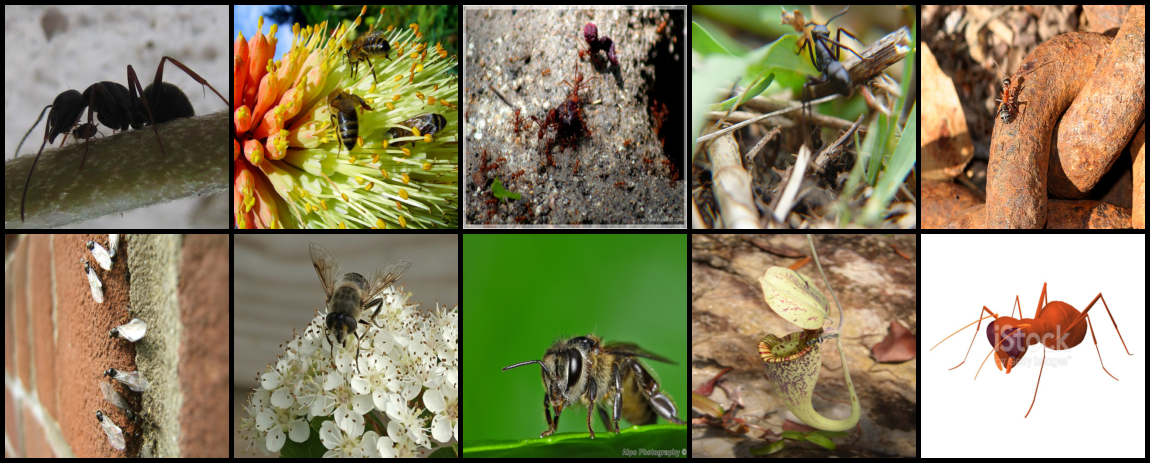

In [136]:
# Generate Train test folder
folder_train_path = os.path.join("dataset","train")
folder_test_path = os.path.join("dataset","val")
classes = {'ants': 0, 'bees': 1}

## -----------  Read Data
class_name =  list(classes.keys())
num_classes = len(class_name)
size = 224 # AlexNet-SqueezeNet-VGG16-Resent18 (224,224)

# ----------- Conter images per classes
# Count number of images
train ={}
test = {}
for c in class_name:
  train[c] = len(os.listdir(os.path.join(folder_train_path,c)))
  test[c] = len(os.listdir(os.path.join(folder_test_path,c)))
print("Number of images per class", train,test)
  
# ---------- Data loader 
train_transform = transforms.Compose([
        transforms.Resize((size,size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
        transforms.Resize((size,size)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

class ImageDataset(Dataset):
    def __init__(self, folder_path,classes,transform=None):
        names = os.listdir(folder_path) 
        self.filepaths = []
        self.y = []
        for c in classes.keys():
            folder_class = os.path.join(folder_path,c)
            names = os.listdir(folder_class)
            f = [os.path.join(folder_path,c,name) for name in names]
            self.filepaths.extend(f)
            self.y.extend([classes[c] for i in range(0,len(f))])
        self.transform = transform
    def __getitem__(self, index):
        filepath = self.filepaths[index]
        y = self.y[index]
        x = Image.open(filepath).convert("RGB")
        #m = np.array(x)
        #print(m)
        if self.transform:
            x =self.transform(x)
        return x,y
    def __len__(self):
        return len(self.filepaths)

train_ds = ImageDataset(folder_train_path,classes,train_transform)
test_ds = ImageDataset(folder_test_path,classes,test_transform)

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=10,shuffle=True)
for x,y in train_dl: 
    print("Outputs", y)
    batch_grid =torchvision.utils.make_grid(x, nrow=5, padding=5)
    im = transforms.ToPILImage()(batch_grid)
    display(im)
    break

## Model  (Transfer Learning)

* [Pytorch Pretrained Models](https://pytorch.org/vision/stable/models.html)
* [Pytorch Transfer learning tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
* [Pytorch Finetuning model](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

In [ ]:
# Pretrained Classification Models
#resnet18 = models.resnet18(pretrained=True)
#alexnet = models.alexnet(pretrained=True)
#squeezenet = models.squeezenet1_0(pretrained=True)
#vgg16 = models.vgg16(pretrained=True)
#densenet = models.densenet161(pretrained=True)
#inception = models.inception_v3(pretrained=True) # two outputs (one auxiliary)! 
#googlenet = models.googlenet(pretrained=True)
#shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
#mobilenet_v2 = models.mobilenet_v2(pretrained=True)
#mobilenet_v3_large = models.mobilenet_v3_large(pretrained=True)
#mobilenet_v3_small = models.mobilenet_v3_small(pretrained=True)
#resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
#wide_resnet50_2 = models.wide_resnet50_2(pretrained=True)
#mnasnet = models.mnasnet1_0(pretrained=True)

In [129]:
def get_number_of_params(model):
  return  sum([param.nelement() for param in model.parameters()])

def freeze_layers(model):
  # Freeze layers! we stop the layers from accumulating gradients
  # we do this for every params in the network
  # we do not wanto to do this for batch norm (bn)
  # We want this to be trained to approximate mean and std of the new dataset!
  for name, param in model.named_parameters():
    if ("bn" not in name):
      param.requires_grad = False # stop gradient prograpagation
    #else: 
    #  print(name)
  return model

def print_children(model):
  # Macro Layer names
  children_names = [name for name, module in model.named_children()]
  print(children_names)

def resnet18_modify(pretrained=True):
  # inject class
  class FinalLayer(nn.Module):
    def __init__(self,in_features, out_features):
      super(FinalLayer, self).__init__()
      self.fc1 = nn.Linear(in_features,512)
      self.fc2 = nn.Linear(512,out_features)
    def forward(self, x):
      x = self.fc1(x)
      x = self.fc2(x)
      return x
  # get  model
  resnet18 = models.resnet18(pretrained=pretrained)
  # copy network
  net = copy.deepcopy(resnet18)
  # Freeze layer (stop accumulating gradient)
  if pretrained:
    freeze_layers(net)
  # print children
  print_children(net)
  # print number of params
  print("N params: ", get_number_of_params(net))
  #  display network summary
  #summary(net, (3, 224, 224), device="cpu")
  # Modify last layer
  print(f"Before {net.fc}")
  #net.fc = nn.Linear(net.fc.in_features,out_features=num_classes)
  net.fc = FinalLayer(net.fc.in_features,out_features=num_classes)
  print(f"After {net.fc}")
  return net

def alexnet_modify(pretrained=True):
  # get model
  alexnet = models.alexnet(pretrained=pretrained)
  # copy network
  net = copy.deepcopy(alexnet)
  if pretrained:
    freeze_layers(net)
  # print children
  print_children(net)
  # print number of params
  print("N params: ", get_number_of_params(net))
  #  display network summary
  summary(net, (3, 224, 224), device="cpu")
  # Freeze layer (prevent updating gradient)
  # Modify last layer
  print(f"Before {net.classifier}")
  net.classifier[6] = nn.Linear(net.classifier[6].in_features,out_features=num_classes)
  print(f"After {net.classifier}")
  return net

def vgg16_modify(pretrained=True):
  vgg16 = models.vgg16(pretrained=pretrained)
  # copy network
  net = copy.deepcopy(vgg16)
  if pretrained:
    freeze_layers(net)
  # print children
  print_children(net)
  # print number of params
  print("N params: ", get_number_of_params(net))
  #  display network summary
  summary(net, (3, 224, 224), device="cpu")
  # Freeze layer (prevent updating gradient)
  # Modify last layer
  print(f"Before {net.classifier}")
  net.classifier[6] = nn.Linear(net.classifier[3].in_features,out_features=num_classes)
  print(f"After {net.classifier}")
  return net

def mobilenet_v3_small_modify(pretrained=True):
  mobilenet_v3_small = models.mobilenet_v3_small(pretrained=pretrained)
  # copy network
  net = copy.deepcopy(mobilenet_v3_small)
  if pretrained:
    freeze_layers(net)
  # print children
  print_children(net)
  # print number of params
  print("N params: ", get_number_of_params(net))
  #  display network summary
  summary(net, (3, 224, 224), device="cpu")
  # Freeze layer (prevent updating gradient)
  # Modify last layer
  print(f"Before {net.classifier}")
  net.classifier[3] = nn.Linear(net.classifier[3].in_features,out_features=num_classes)
  print(f"After {net.classifier}")
  return net

def squeezenet_modify(pretrained=True):
  squeezenet = models.squeezenet1_1(pretrained=pretrained)
  # copy network
  net = copy.deepcopy(squeezenet)
  if pretrained:
    freeze_layers(net)
  # print children
  print_children(net)
  # print number of params
  print("N params: ", get_number_of_params(net))
  #  display network summary
  summary(net, (3, 224, 224), device="cpu")
  # Freeze layer (prevent updating gradient)
  # Modify last layer
  print(f"Before {net.classifier}")
  net.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
  print(f"After {net.classifier}")
  return net

#net = alexnet_modify(pretrained=True)
net = resnet18_modify(pretrained=True)
#net = vgg16_modify(pretrained=True)
#net = mobilenet_v3_small_modify(pretrained=True)
#net = squeezenet_modify(pretrained=True)


['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']
N params:  11689512
Before Linear(in_features=512, out_features=1000, bias=True)
After FinalLayer(
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


## Training 

In [127]:
# Setup GPU Device
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
opt = optim.Adam(net.parameters(),lr=0.001)
train_dl = DataLoader(train_ds,batch_size=20,shuffle=True,num_workers=1)
test_dl = DataLoader(test_ds,batch_size=20,shuffle=True,num_workers=1)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.999)  #  lr = lr * gamma ** last_epoch
params = {
    "model":                 net,
    "loss_func":             nn.CrossEntropyLoss(reduction="sum"), 
    "metric_func":           metrics_func_classification,
    "num_epochs":            20,
    "optimizer":             opt,
    "lr_scheduler":          lr_scheduler,
    "train_dl":              train_dl,
    "test_dl":               test_dl,
    "device":                device,  
    "continue_training" :    False,  # continue training from last save weights
    "sanity_check":          False, # if true we only do one batch per epoch
    "path2weigths":          "./best_model.pt"  
} 
model, loss_history,metric_history = train_test(params)

--> training device cuda:0
----
Epoch 1/20, lr=0.001000
--> model improved! --> saved to ./best_model.pt
--> train_loss: 0.937195, test_loss: 0.417914, train_metric: -0.637, test_metric: -0.797
----
Epoch 2/20, lr=0.000999
--> model improved! --> saved to ./best_model.pt
--> train_loss: 0.290343, test_loss: 0.312016, train_metric: -0.882, test_metric: -0.856
----
Epoch 3/20, lr=0.000998
--> model improved! --> saved to ./best_model.pt
--> train_loss: 0.154995, test_loss: 0.300920, train_metric: -0.943, test_metric: -0.882
----
Epoch 4/20, lr=0.000997
--> model improved! --> saved to ./best_model.pt
--> train_loss: 0.114091, test_loss: 0.181343, train_metric: -0.947, test_metric: -0.941
----
Epoch 5/20, lr=0.000996
--> train_loss: 0.058200, test_loss: 0.254482, train_metric: -0.984, test_metric: -0.915
----
Epoch 6/20, lr=0.000995
--> model improved! --> saved to ./best_model.pt
--> train_loss: 0.067417, test_loss: 0.172805, train_metric: -0.976, test_metric: -0.954
----
Epoch 7/20, lr=

In [133]:
fig_loss = go.Figure()
fig_metric = go.Figure()

x = [i+1 for i in range(params["num_epochs"])]

fig_loss.add_traces( go.Scatter(x=x,y=loss_history["train"], name="train loss", mode="lines+markers" ) )
fig_loss.add_traces( go.Scatter(x=x,y=loss_history["test"], name="test loss"  , mode="lines+markers") )
fig_loss.update_layout(title="Loss Results", xaxis_title="epochs", hovermode="x")
fig_loss.show()

fig_metric.add_traces( go.Scatter(x=x,y=metric_history["train"], name="train metric", mode="lines+markers") )
fig_metric.add_traces( go.Scatter(x=x,y=metric_history["test"], name="test_metric" , mode="lines+markers") )
fig_metric.update_layout(title="Metric Results", xaxis_title="epochs", hovermode="x")
fig_metric.show()

In [140]:
# Load Classification
device = torch.device("cpu")

# Tell the model layer that we are going to use the model in evaluation  mode!
net.eval()

# Predict Classication
cm = np.zeros((num_classes,num_classes))
names_pred = [ "Pred: " + n for n in classes]
with torch.no_grad():
    for x,y in test_dl:
        y_hat = net.forward(x).argmax(dim=-1,keepdim=True).numpy().reshape(-1)
        # Visualize results
        cm += confusion_matrix(y,y_hat)
print("Confusion Matrix")
df = pd.DataFrame(cm, columns=names_pred, index=classes)
display(df)

Confusion Matrix


,Pred: ants,Pred: bees
ants,67.0,3.0
bees,4.0,79.0


## Test 

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']
N params:  11689512
Before Linear(in_features=512, out_features=1000, bias=True)
After FinalLayer(
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)
bees


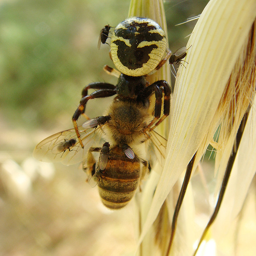

bees


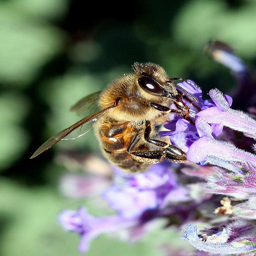

bees


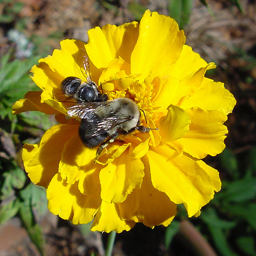

ants


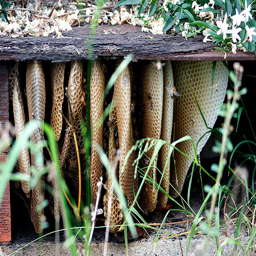

bees


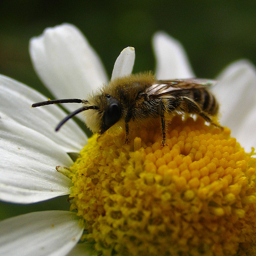

bees


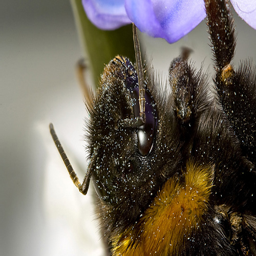

bees


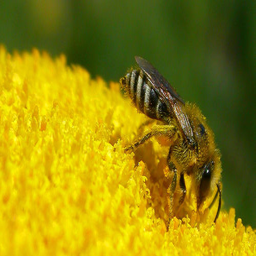

bees


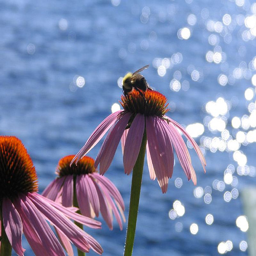

bees


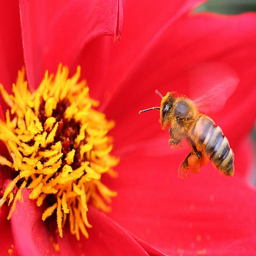

bees


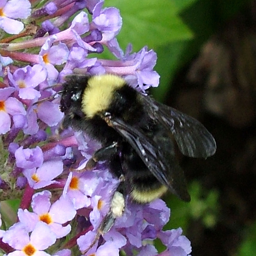

bees


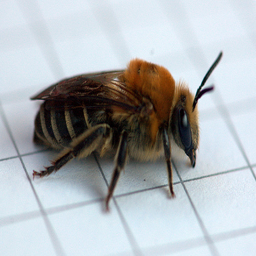

bees


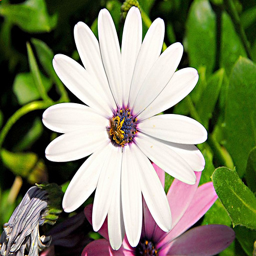

bees


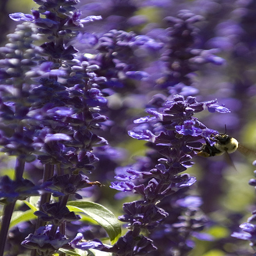

bees


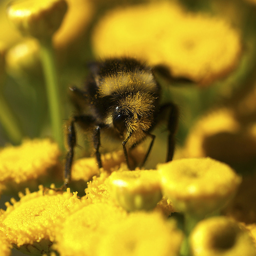

bees


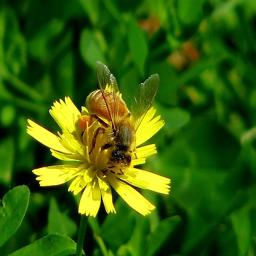

bees


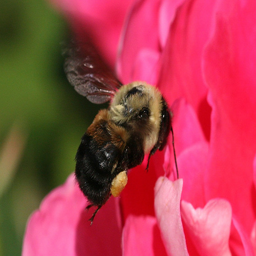

bees


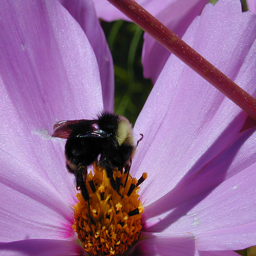

In [132]:
# Read Image
def preprocess_image(filepath,size=256):
    #filepath = os.path.join("covid-mask-classifier","dataset","mask","5e7cded7ba85ee690669c204.jpg")
    im_pil = Image.open(filepath).convert("RGB").resize((256,256))
    im_tensor = transforms.ToTensor()( im_pil ).unsqueeze(0)
    return im_tensor, im_pil

# Load Model
device = torch.device("cpu")
classes = {'ants': 0, 'bees': 1}
class_name =  list(classes.keys())
#net = AlexNet(len(classes)).to(device)
net = resnet18_modify(pretrained=False).to(device)
path2weights = "best_model.pt"
weights = torch.load(path2weights)
net.load_state_dict(weights)
size  = 256 # Training size shape

# Tell the model layer that we are going to use the model in evaluation  mode!
net.eval()

# Predict
#folder_path = os.path.join("dataset","val","ants")
folder_path = os.path.join("dataset","val","bees")
names = os.listdir(folder_path)
filepaths = [os.path.join(folder_path,name) for name in names]
for filepath in filepaths[3:20]:  # Show only 5 images
    im_tensor, im_pil = preprocess_image(filepath,size)
    with torch.no_grad():
        out = net.forward(im_tensor).argmax(dim=-1,keepdim=True).item()
    print(class_name[out])
    display( im_pil )

###  Extra: [Pytorch Hub](https://pytorch.org/hub/)

In [113]:
# pytorch hub vision
import torch
modelList = torch.hub.list("pytorch/vision")
display(modelList)

model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v3_small', pretrained=True)
#model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


['alexnet',
 'deeplabv3_mobilenet_v3_large',
 'deeplabv3_resnet101',
 'deeplabv3_resnet50',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'fcn_resnet101',
 'fcn_resnet50',
 'googlenet',
 'inception_v3',
 'lraspp_mobilenet_v3_large',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn',
 'wide_resnet101_2',
 'wide_resnet50_2']

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
